<a href="https://colab.research.google.com/github/MariGaS/Proyecto_Tecnologico/blob/main/vectorization_bigrams.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import nltk 
from nltk import TweetTokenizer
import numpy as np
import xml.etree.ElementTree as ET
import os
import re
from os import listdir
from os.path import isfile, join
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_fscore_support, roc_auc_score
import sklearn

In [ ]:
from nltk.util import ngrams
import collections

In [ ]:
def get_urls(path): 
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
    onlyfiles.sort()

    return onlyfiles

In [ ]:
def get_text_post_train(user_path):
    tree = ET.parse(user_path)
    root = tree.getroot()
    hist_post = [] # list with entries from the user 

    #iterate recursively over all the sub-tree 
    #source : https://docs.python.org/3/library/xml.etree.elementtree.html
    for post in root.iter('WRITING'): 

        for t in post.iter('TITLE'):
            entry = t.text
            entry = entry.replace('\n', ' ') 
            if entry == ' ' or entry == '  ':
                continue 
            else: 
                hist_post.append(entry[1:-1])
        for t in post.iter('TEXT'):
            entry = t.text
            entry = entry.replace('\n', ' ') 
            if entry == ' ' or entry == '  ':
                continue 
            else: 
                hist_post.append(entry[1:-1])

    
    ##--------concatenate post -------------#
    all_post = "" #concatenate all post 
    for i in range(len(hist_post)):
        all_post = all_post + hist_post[i] + " "
    
    return all_post 

In [ ]:
def get_text_labels(path, polarity = 'Negative'): 
    all_documents = [] #list with all the documents 
    all_label = [] #label 

    user_path = get_urls(path)
    for i in range(len(user_path)): 
        subject = user_path[i] #for example test_subjet1005.xml 
        path_subject = path + '/' + subject 
        document = get_text_post_train(path_subject) #get document with all the history of a user 

        all_documents += [document] 
        if polarity == 'Negative' : 
            all_label += [0]
        else: 
            all_label += [1]

    return all_documents, all_label 


In [ ]:
def get_text_chunk(path): 
    all_documents = [] #list with all the documents 
    all_label = [] #label 

    user_path = get_urls(path)
    for i in range(len(user_path)): 
        subject = user_path[i] #for example test_subjet1005.xml 
        path_subject = path + '/' + subject 
        document = get_text_post_train(path_subject) #get document with all the history of a user 

        all_documents += [document] 
    return all_documents

# Extraer train data

In [ ]:
anxia_test = '/content/drive/MyDrive/Proyecto_Tecnologico/Data/Anorexia Datasets_1/test'
anxia_train = '/content/drive/MyDrive/Proyecto_Tecnologico/Data/Anorexia Datasets_1/train'

In [ ]:
pos = 'positive_examples'
neg = 'negative_examples'

all_pos = []
all_neg = []
for i in range(1,11):
    path_chunk_pos = anxia_train +'/' + pos + '/chunk'+str(i)
    path_chunk_neg = anxia_train +'/' + neg + '/chunk'+str(i)

    temp1 = get_text_chunk(path_chunk_pos)
    temp2 = get_text_chunk(path_chunk_neg)
    if i == 1: 
        all_pos = temp1
        all_neg = temp2
    else: 
        for j in range(len(temp1)):
            all_pos[j] += temp1[j]
    
        for j in range(len(temp2)):
            all_neg[j] += temp2[j]
    

In [ ]:
tr_anorexia = [*all_pos, *all_neg]

In [ ]:
tr_label = []
for i in range(len(tr_anorexia)):
    if i < 20: 
        tr_label.append(1)
    else:
        tr_label.append(0)

Counter({0: 132, 1: 20})


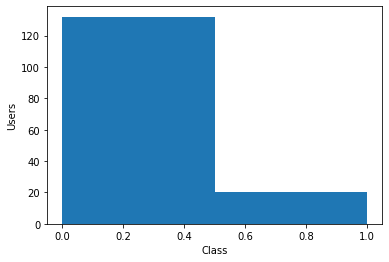

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

print(Counter(tr_label))
plt.hist(tr_label, bins=len(set(tr_label)))
plt.ylabel('Users');
plt.xlabel('Class');

# Test data

In [ ]:
test_url_anxia   = []
test_labels_anxia = []

with open('/content/drive/MyDrive/Proyecto_Tecnologico/Data/Anorexia Datasets_1/test/test_golden_truth.txt') as f:
    lines = f.readlines()
    for line in lines: 

        test_url_anxia.append(line[:-3]) #only the name of the subject 

        test_labels_anxia.append(int(line[-2:-1])) #only the label
    f.close()

In [ ]:
def get_text_test_anorexia(path, list_subject, chunk): 
    all_documents = [] #list with all the documents 
    all_label = [] #label 

    for i in range(len(list_subject)): 
        subject = list_subject[i] #for example test_subjet1005.xml 
        path_subject = path + '/chunk'+ str(chunk) + '/' + subject + '_' + str(chunk) + '.xml'
        
        document = get_text_post_train(path_subject) #get document with all the history of a user 
        
        all_documents += [document] 
    print("text extracted for all users")
    return all_documents

In [ ]:
test_anxia = []
for i in range(1,11):

    temp1 = get_text_test_anorexia(anxia_test, test_url_anxia, i)

    if i == 1: 
        test_anxia = temp1
        print("Text extracted from chunk: ", i)
    else: 

        for j in range(len(temp1)):
            test_anxia[j] += temp1[j]
        print("Text extracted from chunk: ", i)

text extracted for all users
Text extracted from chunk:  1
text extracted for all users
Text extracted from chunk:  2
text extracted for all users
Text extracted from chunk:  3
text extracted for all users
Text extracted from chunk:  4
text extracted for all users
Text extracted from chunk:  5
text extracted for all users
Text extracted from chunk:  6
text extracted for all users
Text extracted from chunk:  7
text extracted for all users
Text extracted from chunk:  8
text extracted for all users
Text extracted from chunk:  9
text extracted for all users
Text extracted from chunk:  10


In [ ]:
def normalize(document): 

    document = [x.lower()  for x in document]
    document = [re.sub(r'https?:\/\/\S+', '', x) for x in document] #eliminate url
    document = [re.sub(r"www\.[a-z]?\.?(com)+|[a-z]+\.(com)", '', x) for x in document] #eliminate url 
    document = [re.sub(r'{link}', '', x) for x in document] #eliminate link
    document = [re.sub(r"\[video\]", '', x) for x in document] #eliminate video 
    document = [re.sub(r'\s+', ' ' '', x).strip() for x in document]
    document = [re.sub(r',', ' ' '', x).strip() for x in document]
    document = [x.replace("#","") for x in document]  #eliminate #
    document = [re.subn(r'[^\w\s,]',"", x)[0].strip() for x in document] #eliminate emoticons 

    return document

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords

In [ ]:
def remove_stop_list(document):
    document = [remove_stopwords(x)  for x in document]

    return document

In [ ]:
data_pos = remove_stop_list(all_pos)

In [ ]:
data_pos = normalize(data_pos)

In [ ]:
tokenizer = TweetTokenizer()

In [ ]:
def get_corpus(text):
    corpus_palabras = []
    for doc in text: 
        corpus_palabras += tokenizer.tokenize(doc)
    return corpus_palabras

In [ ]:
c = get_corpus(data_pos)

In [ ]:
esBigrams = ngrams(c, 2)

In [ ]:
# get the frequency of each bigram in our corpus
#https://www.kaggle.com/code/rtatman/tutorial-getting-n-grams 
esBigramFreq = collections.Counter(esBigrams)

# what are the ten most popular ngrams in this Spanish corpus?
l = esBigramFreq.most_common(50)

In [ ]:
def get_bigrams(data, num_bigrams):
    corpus = get_corpus(data)
    esBigrams = ngrams(corpus, 2)
    esBigramFreq = collections.Counter(esBigrams)
    l = esBigramFreq.most_common(num_bigrams)

    bigrams = []
    for i in range(len(l)):
        w1 = l[i][0][0]
        w2 = l[i][0][1]

        w = w1 + '_' + w2
        bigrams.append(w)
    
    return bigrams

In [ ]:
def get_words(fdist_doc):
    '''
    For each user we have the dictionary of frequency of their words
    we have a reduced list by check is their words have a representation
    in GloVe

    Return: List
    '''
    words_doc = []
    for i,word in fdist_doc:
        #if word.isnumeric() == False:
            #embeddings_vector = model.wv[word]
            #if embeddings_vector is not None: 
        words_doc.append(word)
    
    return words_doc

In [ ]:
def get_dic_bigram(fdist1, bigrams):
    words1 = get_words(fdist1)
    words = words1 + bigrams
    vocab_plus = set(words)
    #vocab_emb = get_words_dic(vocab_plus)
    value = [x for x in range(len(vocab_plus))] 
    dictionary = dict(zip(value, words)) # nuevo diccionario 

    return dictionary

In [ ]:
from gensim.models import FastText
model = FastText.load('/content/drive/MyDrive/Proyecto_Tecnologico/Model/fasttext_anxiety.model')

In [ ]:
def get_fuzzy_rep(words_doc, dictionary, epsilon):
    words_user = np.zeros((len(words_doc),300) , dtype=float)
    dictionary_vec = np.zeros((len(set(dictionary)),300) ,dtype=float)

    for i in range(words_user.shape[0]): 
        w1 = words_doc[i]         
        words_user[i] = model.wv[w1]

    for i in range(dictionary_vec.shape[0]): 
        w1 = dictionary[i]         
        dictionary_vec[i] = model.wv[w1]

    similarity_vocab = sklearn.metrics.pairwise.cosine_similarity(words_user, dictionary_vec)
    #vector de representación
    vec_representation = np.count_nonzero(similarity_vocab > epsilon , axis=0)

     
    return vec_representation


In [ ]:
def sortFreqDict(freqdict):
        aux = [(freqdict[key],key) for key in freqdict]
        aux.sort()
        aux.reverse()
        return aux 

In [ ]:
def get_fdist(text, num_feat):
    corpus_palabras = []
    for doc in text: 
        corpus_palabras += tokenizer.tokenize(doc)
    fdist = nltk.FreqDist(corpus_palabras)
    fdist = sortFreqDict(fdist)
    fdist = fdist[:num_feat]
    return fdist

In [ ]:

def classificator_pos_neg(pos_data, neg_data, test, num_feat, num_bigrams, tau, remove_stop = False):
    if remove_stop == True: 
        print("quitando stopwords")
        pos_data = remove_stop_list(pos_data)
        neg_data = remove_stop_list(neg_data)
        test     = remove_stop_list(test)

    pos_data = normalize(pos_data)
    neg_data = normalize(neg_data)
    test = normalize(test)


    num_test = len(test)

    fdist_pos = get_fdist(pos_data, num_feat)
    fdist_neg = get_fdist(neg_data, num_feat)

    bigrams1 = get_bigrams(pos_data, num_bigrams)
    bigrams2 = get_bigrams(neg_data, num_bigrams)
    dictionary1 = get_dic_bigram(fdist_pos, bigrams1)
    dictionary2 = get_dic_bigram(fdist_neg, bigrams2)
    
    
    X_test1 = np.zeros((num_test,len(dictionary1)) ,dtype=float) #matriz tipo document-term
    X_test2 = np.zeros((num_test,len(dictionary2)) ,dtype=float)

    print("inicio vectorizacion con pos ")
    for i in range(num_test): 
        doc = test[i]
        corpus_palabras = tokenizer.tokenize(doc.lower())
        fdist = nltk.FreqDist(corpus_palabras)
        v = sortFreqDict(fdist)
        words_doc =  get_words(v) 
        bigrams_test1 = get_bigrams(doc, num_bigrams)
        words_doc = words_doc + bigrams_test1
        word_repre_user = get_fuzzy_rep(words_doc, dictionary1, epsilon = tau)
        X_test1[i] = word_repre_user
    print('end')
    print("inicio vectorizacion con neg")
    for i in range(num_test): 
        doc = test[i]
        corpus_palabras = tokenizer.tokenize(doc.lower())
        fdist = nltk.FreqDist(corpus_palabras)
        v = sortFreqDict(fdist)
        words_doc =  get_words(v) 
        bigrams_test2 = get_bigrams(doc, num_bigrams)
        words_doc = words_doc + bigrams_test2
        word_repre_user = get_fuzzy_rep(words_doc, dictionary2, epsilon = tau)
        X_test2[i] = word_repre_user
    #print("Vectorization for test data: Done")
    print('end')
    X_test1 = np.sum(X_test1, axis = 1)  
    X_test2 = np.sum(X_test2, axis = 1)  

    results = np.zeros((num_test), dtype = int)
    for i in range(num_test):
        if X_test1[i] > X_test2[i]:
            results[i] = 1
        else: 
            results[i] = 0
    return results, X_test1, X_test2





In [ ]:

results5, x, y = classificator_pos_neg(all_pos, all_neg, test_anxia, 500,50, 0.99, remove_stop= True)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, results5, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia,results5))
print(metrics.classification_report(test_labels_anxia,results5))

quitando stopwords
inicio vectorizacion con pos 
end
inicio vectorizacion con neg
end
[[274   5]
 [ 13  28]]
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       279
           1       0.85      0.68      0.76        41

    accuracy                           0.94       320
   macro avg       0.90      0.83      0.86       320
weighted avg       0.94      0.94      0.94       320



In [ ]:

results5, x, y = classificator_pos_neg(all_pos, all_neg, test_anxia, 450,100, 0.99, remove_stop= True)
p , r, f, _ = precision_recall_fscore_support(test_labels_anxia, results5, average = 'macro', pos_label = 1)

print(confusion_matrix(test_labels_anxia,results5))
print(metrics.classification_report(test_labels_anxia,results5))

quitando stopwords
inicio vectorizacion con pos 
end
inicio vectorizacion con neg
end
[[272   7]
 [ 15  26]]
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       279
           1       0.79      0.63      0.70        41

    accuracy                           0.93       320
   macro avg       0.87      0.80      0.83       320
weighted avg       0.93      0.93      0.93       320

